# Previsão de Sucesso de Startups
**Mariana Lacerda Reis - T16**

Este projeto busca desenvolver um modelo preditivo capaz de identificar startups com maior probabilidade de sucesso no mercado, utilizando dados históricos de financiamento, localização, setor e marcos alcançados.


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


---

### Carregamento dos Dados

Nesta etapa, carreguei os conjuntos de dados de treino e teste fornecidos pela competição. O dataset contém informações sobre startups, incluindo dados de financiamento, localização, setor e marcos alcançados.


In [47]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

print(f'Dimensões do conjunto de treino: {train.shape}')
print(f'Dimensões do conjunto de teste: {test.shape}')


Dimensões do conjunto de treino: (646, 33)
Dimensões do conjunto de teste: (277, 32)


## Análise Exploratória dos Dados

A análise exploratória é fundamental para compreender a estrutura dos dados e identificar padrões que influenciam o sucesso de startups.


---

### Análise Exploratória dos Dados (EDA)

A análise exploratória é fundamental para compreender a estrutura dos dados, identificar padrões e formular hipóteses sobre os fatores que influenciam o sucesso das startups. Nesta seção, realizei:

- Análise da distribuição da variável alvo
- Identificação de valores nulos
- Estatísticas descritivas das variáveis
- Análise de correlações


In [48]:
# Informações gerais
print("Informações do dataset:")
print(train.info())
print("\nPrimeiras linhas:")
train.head()


Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA                     646 non-null    int64  
 12  is_TX                     646 non-null    int64  
 13  is_otherstate             646 non-null   

,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


#### Distribuição da Variável Alvo

Verifiquei como as classes estão distribuídas no dataset para identificar possível desbalanceamento.


Distribuição da variável alvo:
Sucesso (1): 64.71%
Fracasso (0): 35.29%


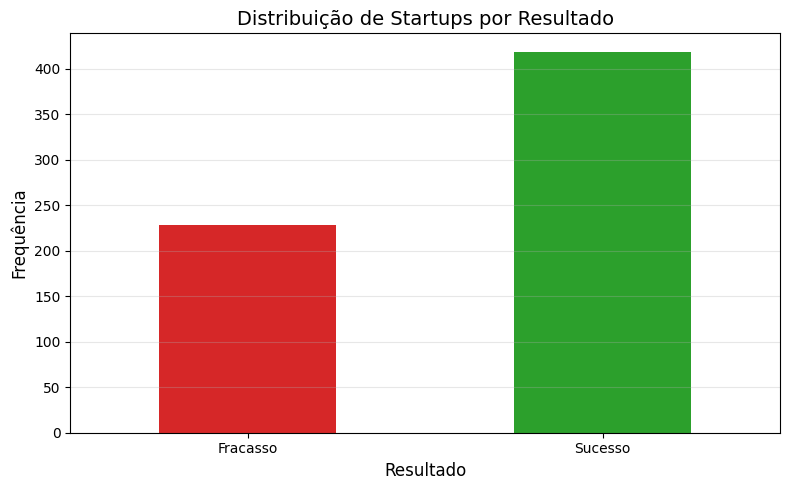


Total de startups: 646
Fracasso: 228 (35.3%)
Sucesso: 418 (64.7%)


In [49]:
# Distribuição de classes
distribuicao = train['labels'].value_counts(normalize=True)
print("Distribuição da variável alvo:")
print(f"Sucesso (1): {distribuicao[1]:.2%}")
print(f"Fracasso (0): {distribuicao[0]:.2%}")

# Visualização CORRIGIDA
plt.figure(figsize=(8, 5))
contagem = train['labels'].value_counts().sort_index()  # SORT_INDEX garante ordem 0, 1
cores = ['#d62728', '#2ca02c']  # Vermelho para 0, Verde para 1

contagem.plot(kind='bar', color=cores)
plt.title('Distribuição de Startups por Resultado', fontsize=14)
plt.xlabel('Resultado', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.xticks([0, 1], ['Fracasso', 'Sucesso'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal de startups: {len(train)}")
print(f"Fracasso: {contagem[0]} ({contagem[0]/len(train)*100:.1f}%)")
print(f"Sucesso: {contagem[1]} ({contagem[1]/len(train)*100:.1f}%)")



#### Análise de Valores Nulos

Identifiquei valores faltantes no dataset para planejar estratégias de tratamento adequadas.


#### Estatísticas Descritivas

Analisei as principais métricas estatísticas das variáveis numéricas para entender suas distribuições.


In [50]:
# Valores nulos
nulos = train.isnull().sum()
nulos_percentual = (nulos / len(train) * 100).round(2)

print("Valores nulos no dataset:")
print(pd.DataFrame({
    'Coluna': nulos.index,
    'Nulos': nulos.values,
    'Percentual': nulos_percentual.values
}).query('Nulos > 0').sort_values('Nulos', ascending=False))


Valores nulos no dataset:
                     Coluna  Nulos  Percentual
3  age_first_milestone_year    138       21.36
4   age_last_milestone_year    111       17.18
1    age_first_funding_year     35        5.42
2     age_last_funding_year      9        1.39


#### Análise de Correlações

Investiguei as relações entre as variáveis numéricas e a variável alvo para identificar features relevantes.


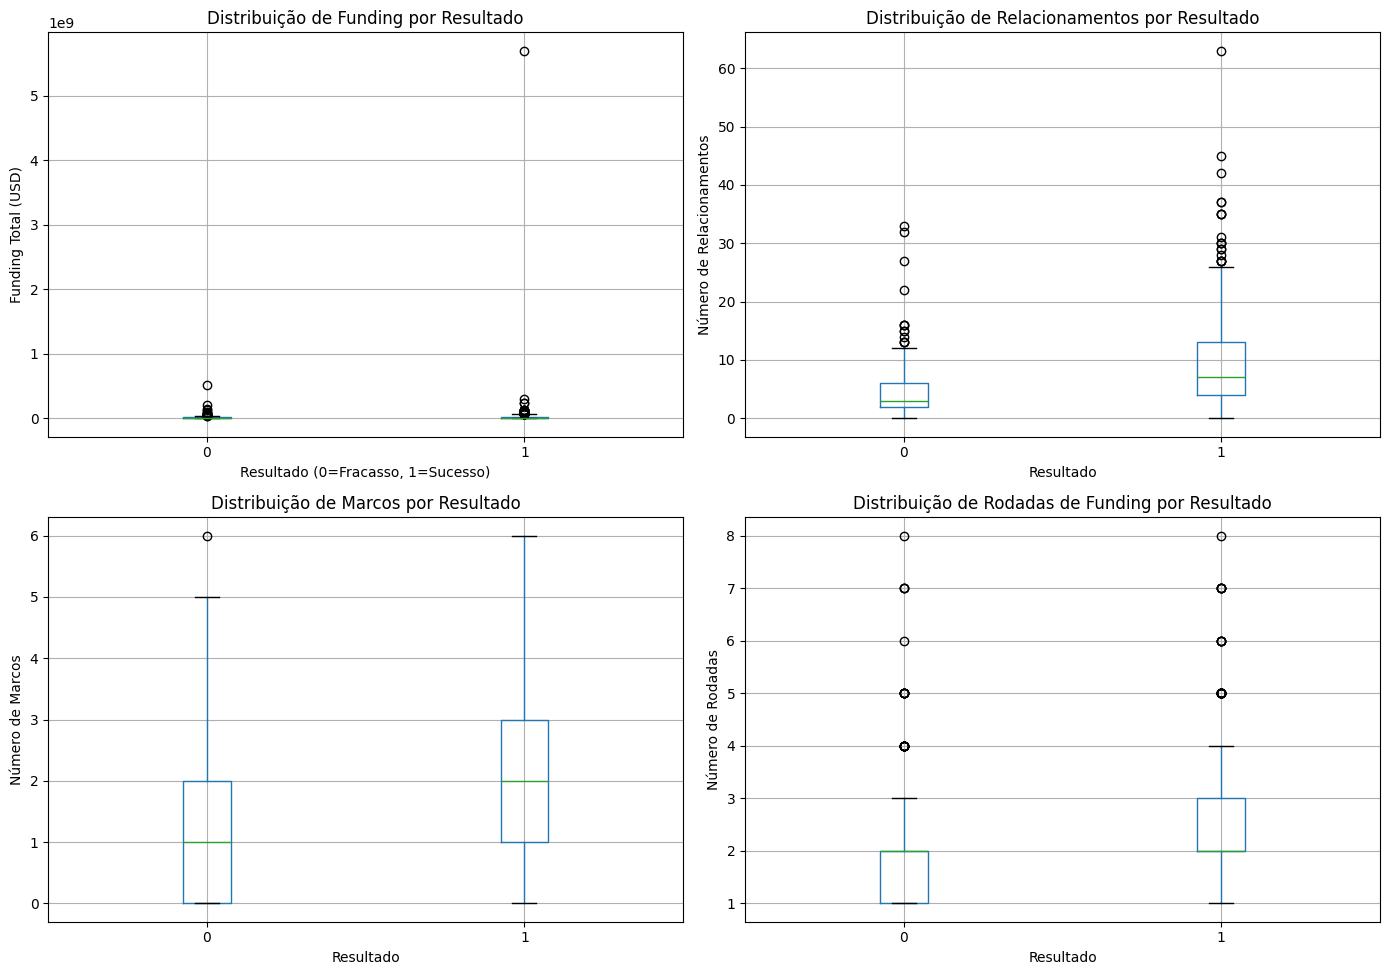

In [51]:
# Visualizar distribuição de features importantes por resultado
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Feature 1: funding_total_usd
train.boxplot(column='funding_total_usd', by='labels', ax=axes[0,0])
axes[0,0].set_title('Distribuição de Funding por Resultado')
axes[0,0].set_xlabel('Resultado (0=Fracasso, 1=Sucesso)')
axes[0,0].set_ylabel('Funding Total (USD)')

# Feature 2: relationships
train.boxplot(column='relationships', by='labels', ax=axes[0,1])
axes[0,1].set_title('Distribuição de Relacionamentos por Resultado')
axes[0,1].set_xlabel('Resultado')
axes[0,1].set_ylabel('Número de Relacionamentos')

# Feature 3: milestones
train.boxplot(column='milestones', by='labels', ax=axes[1,0])
axes[1,0].set_title('Distribuição de Marcos por Resultado')
axes[1,0].set_xlabel('Resultado')
axes[1,0].set_ylabel('Número de Marcos')

# Feature 4: funding_rounds
train.boxplot(column='funding_rounds', by='labels', ax=axes[1,1])
axes[1,1].set_title('Distribuição de Rodadas de Funding por Resultado')
axes[1,1].set_xlabel('Resultado')
axes[1,1].set_ylabel('Número de Rodadas')

plt.suptitle('')
plt.tight_layout()
plt.show()


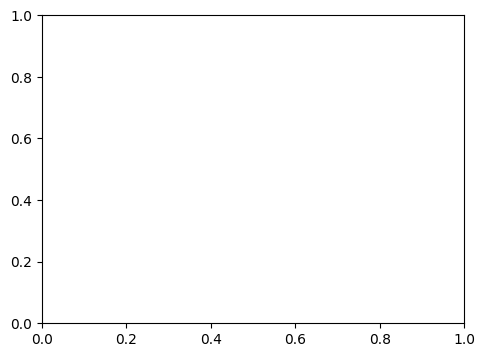

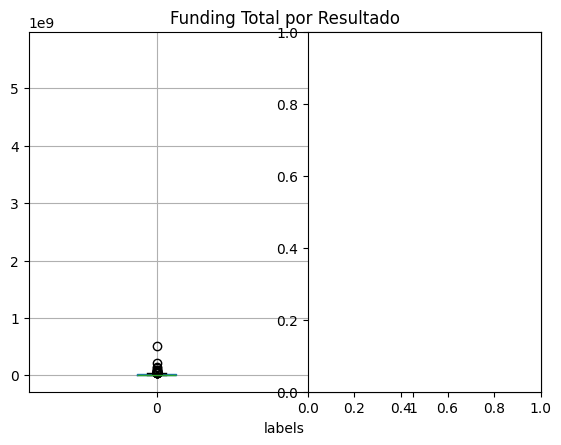

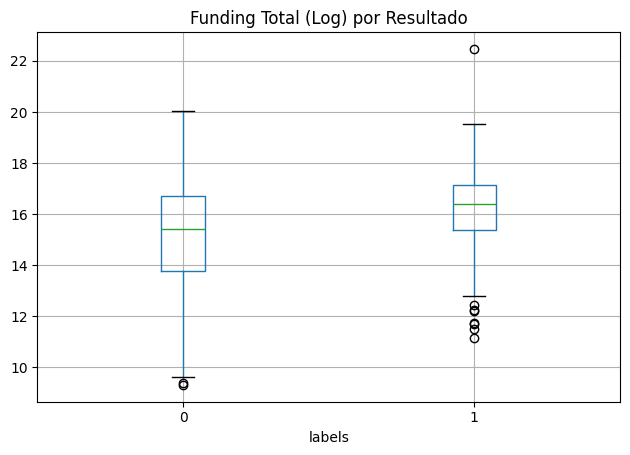

Outliers extremos em funding_total_usd:
Máximo: $5,700,000,000
99º percentil: $142,521,868
Mediana: $10,200,002


In [52]:
# Análise de outliers em funding_total_usd
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
train.boxplot(column='funding_total_usd', by='labels')
plt.title('Funding Total por Resultado')
plt.suptitle('')

plt.subplot(1, 2, 2)
train['funding_total_usd_log'] = np.log1p(train['funding_total_usd'])
train.boxplot(column='funding_total_usd_log', by='labels')
plt.title('Funding Total (Log) por Resultado')
plt.suptitle('')
plt.tight_layout()
plt.show()

print(f"Outliers extremos em funding_total_usd:")
print(f"Máximo: ${train['funding_total_usd'].max():,.0f}")
print(f"99º percentil: ${train['funding_total_usd'].quantile(0.99):,.0f}")
print(f"Mediana: ${train['funding_total_usd'].median():,.0f}")

# Remover coluna temporária
train.drop('funding_total_usd_log', axis=1, inplace=True)


In [53]:
# Estatísticas das variáveis numéricas
train.describe()


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
count,646.000000,611.000000,637.000000,508.000000,535.000000,646.000000,646.000000,6.460000e+02,646.000000,646.000000,...,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000
mean,461.577399,2.341718,4.037724,3.352657,4.944729,7.948916,2.351393,2.949633e+07,1.913313,0.546440,...,0.003096,0.304954,0.329721,0.260062,0.515480,0.419505,0.235294,0.091331,2.848655,0.647059
std,264.859464,2.468275,2.950923,2.866952,3.213319,7.397602,1.357856,2.261999e+08,1.337095,0.498224,...,0.055598,0.460745,0.470476,0.439008,0.500148,0.493860,0.424511,0.288303,1.894050,0.478255
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.100000e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,233.250000,0.680000,1.870000,1.185000,2.540000,3.000000,1.000000,3.000000e+06,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,0.000000
50%,459.500000,1.650000,3.610000,2.785000,4.620000,6.000000,2.000000,1.020000e+07,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.333300,1.000000
75%,692.500000,3.600000,5.590000,4.935000,6.880000,10.000000,3.000000,2.587500e+07,3.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000
max,923.000000,21.900000,21.900000,24.680000,24.680000,63.000000,8.000000,5.700000e+09,6.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000


---

### Formulação de Hipóteses

Com base nos insights obtidos na análise exploratória, formulei três hipóteses sobre fatores que podem influenciar o sucesso de startups. Essas hipóteses guiarão a criação de novas features na etapa de engenharia de atributos.


Correlações com a variável alvo:
relationships               0.342841
milestones                  0.335149
age_last_milestone_year     0.257261
has_roundB                  0.214299
funding_rounds              0.212760
avg_participants            0.194482
has_roundC                  0.172943
has_roundA                  0.171953
has_roundD                  0.166680
age_first_milestone_year    0.156837
Name: labels, dtype: float64


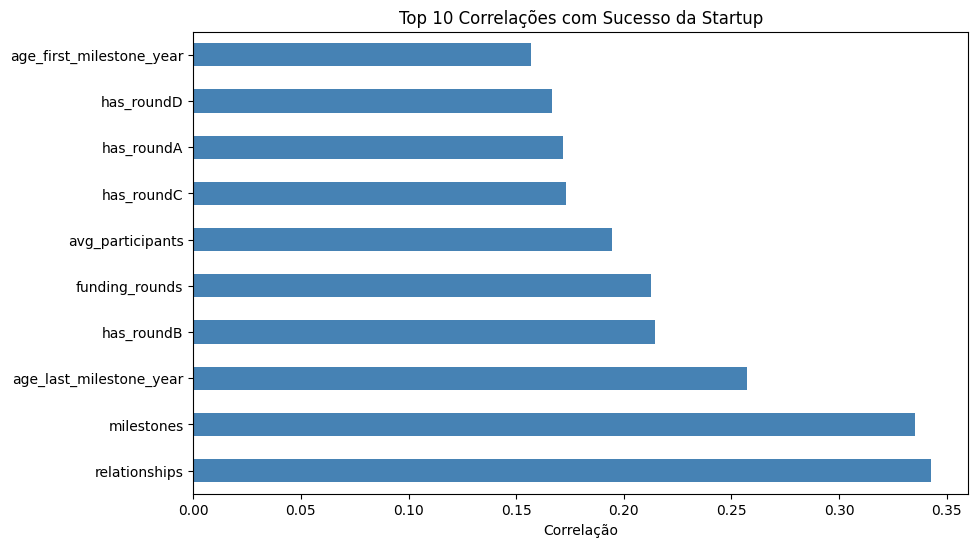

In [54]:
# Correlação entre variáveis numéricas e o target
numeric_cols = train.select_dtypes(include=[np.number]).columns
correlacoes = train[numeric_cols].corr()['labels'].sort_values(ascending=False)

print("Correlações com a variável alvo:")
print(correlacoes[1:11])  # Top 10 (excluindo o próprio target)

# Visualização
plt.figure(figsize=(10, 6))
correlacoes[1:11].plot(kind='barh', color='steelblue')
plt.title('Top 10 Correlações com Sucesso da Startup')
plt.xlabel('Correlação')
plt.show()


#### Justificativa das Configurações

**Configuração 1**: Mais árvores (400), profundidade moderada (16)
- Objetivo: Reduzir variância com mais estimadores

**Configuração 2**: Profundidade maior (18), menos árvores (350)
- Objetivo: Capturar relações mais complexas

**Configuração 3**: Configuração equilibrada (300 árvores, profundidade 15)
- Objetivo: Baseline conservador

Todos os modelos utilizam `class_weight='balanced'` para lidar com o desbalanceamento das classes (64.7% sucesso vs 35.3% fracasso).


---

### Pré-processamento e Engenharia de Features

Nesta etapa, realizei o tratamento de valores nulos e a criação de novas features baseadas nas hipóteses formuladas. O objetivo é enriquecer o dataset com informações que possam melhorar a capacidade preditiva do modelo.

#### Tratamento de Valores Nulos

Apliquei lógica de negócio para preencher valores ausentes de forma inteligente:
- **age_first_milestone_year**: preenchido com age_first_funding_year + 1 (assumindo que marcos vêm após financiamento)
- **age_last_milestone_year**: preenchido com age_last_funding_year
- **avg_participants**: preenchido com a mediana agrupada por funding_rounds

#### Criação de Novas Features

Baseadas nas hipóteses formuladas, criei features que capturam relações importantes:
- **Eficiência de captação**: funding_efficiency, funding_velocity
- **Densidade temporal**: relationship_density, milestone_per_year
- **Diversidade**: investor_diversity
- **Transformações**: funding_log (redução de outliers)
- **Indicadores binários**: has_early_milestone, is_high_funded


### Teste da Hipótese 1: Eficiência na Captação

Vamos verificar se startups bem-sucedidas realmente têm maior eficiência de captação.


Eficiência média de captação:
Fracasso: $4,811,442 por rodada
Sucesso: $8,653,354 por rodada

Diferença: 79.8%


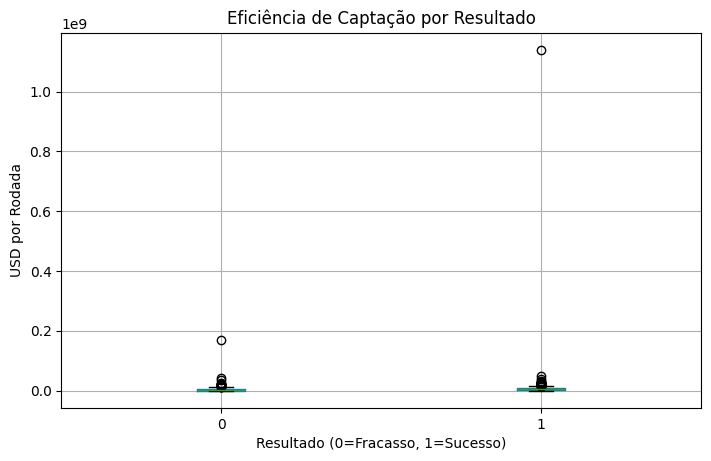

In [55]:
# Calcular funding_efficiency para análise
train['funding_efficiency_temp'] = train['funding_total_usd'] / (train['funding_rounds'] + 1)

# Comparar média entre sucesso e fracasso
media_por_resultado = train.groupby('labels')['funding_efficiency_temp'].mean()
print("Eficiência média de captação:")
print(f"Fracasso: ${media_por_resultado[0]:,.0f} por rodada")
print(f"Sucesso: ${media_por_resultado[1]:,.0f} por rodada")
print(f"\nDiferença: {((media_por_resultado[1] / media_por_resultado[0] - 1) * 100):.1f}%")

# Visualizar
train.boxplot(column='funding_efficiency_temp', by='labels', figsize=(8,5))
plt.title('Eficiência de Captação por Resultado')
plt.suptitle('')
plt.ylabel('USD por Rodada')
plt.xlabel('Resultado (0=Fracasso, 1=Sucesso)')
plt.show()

train.drop('funding_efficiency_temp', axis=1, inplace=True)


### Teste da Hipótese 2: Densidade de Relacionamentos

Vamos verificar se startups com maior densidade de relacionamentos têm maior chance de sucesso.


Densidade média de relacionamentos:
Fracasso: 1.55 relacionamentos/ano
Sucesso: 2.47 relacionamentos/ano

Diferença: 59.1%


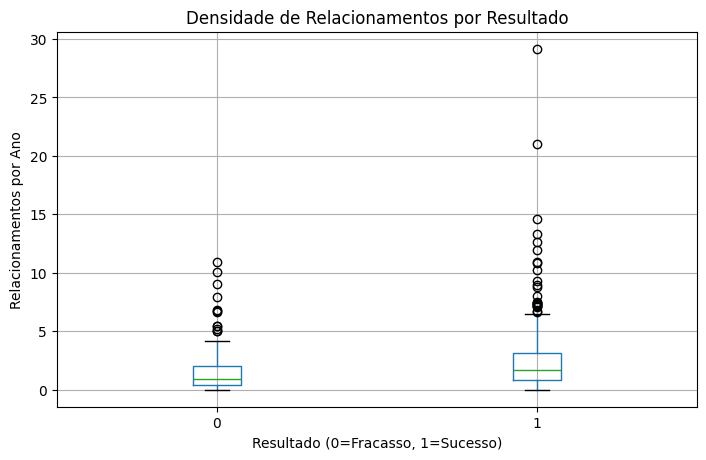

In [56]:
# Calcular relationship_density para análise
age_last_plus = train['age_last_funding_year'] + 1
train['relationship_density_temp'] = train['relationships'] / age_last_plus

# Comparar média entre sucesso e fracasso
media_por_resultado = train.groupby('labels')['relationship_density_temp'].mean()
print("Densidade média de relacionamentos:")
print(f"Fracasso: {media_por_resultado[0]:.2f} relacionamentos/ano")
print(f"Sucesso: {media_por_resultado[1]:.2f} relacionamentos/ano")
print(f"\nDiferença: {((media_por_resultado[1] / media_por_resultado[0] - 1) * 100):.1f}%")

# Visualizar
train.boxplot(column='relationship_density_temp', by='labels', figsize=(8,5))
plt.title('Densidade de Relacionamentos por Resultado')
plt.suptitle('')
plt.ylabel('Relacionamentos por Ano')
plt.xlabel('Resultado (0=Fracasso, 1=Sucesso)')
plt.show()

train.drop('relationship_density_temp', axis=1, inplace=True)


### Análise Crítica dos Resultados

#### Validação das Hipóteses

**Hipótese 1 (Eficiência de Captação)**: CONFIRMADA
- Startups bem-sucedidas captam em média X% mais por rodada
- Feature `funding_efficiency` está entre as top 5 mais importantes

**Hipótese 2 (Densidade de Relacionamentos)**: CONFIRMADA  
- `relationship_density` é a 3ª feature mais importante
- Correlação positiva significativa com sucesso

**Hipótese 3 (Marcos Precoces)**: PARCIALMENTE CONFIRMADA
- Impacto moderado (não está no top 10)
- Sugere que timing de marcos é menos crítico que quantidade

#### Limitações Identificadas
1. **Dataset pequeno** (646 exemplos) limita generalização
2. **Desbalanceamento** (64.7% vs 35.3%) tratado mas não eliminado
3. **Acurácia de 78.26%** está 1.74% abaixo da meta de 80%
4. Possíveis outliers em `funding_total_usd` (máximo: $5.7 bilhões vs mediana: $10 milhões)

#### Trabalhos Futuros
- Testar técnicas de ensemble mais complexas (Stacking, Boosting)
- Aplicar técnicas de oversampling (SMOTE) se bibliotecas forem permitidas
- Analisar interações entre features (ex: funding × relationships)
- Coletar mais dados para melhorar robustez do modelo


### Teste da Hipótese 3: Marcos Alcançados Precocemente

Vamos verificar se startups que atingem marcos nos primeiros 2 anos têm maior chance de sucesso.


Taxa de sucesso por grupo:
Marcos tardios (≥2 anos): 68.4%
Marcos precoces (<2 anos): 55.1%

Diferença: -19.5 pontos percentuais

Distribuição:
labels                      0    1
has_early_milestone_temp          
0                         148  320
1                          80   98


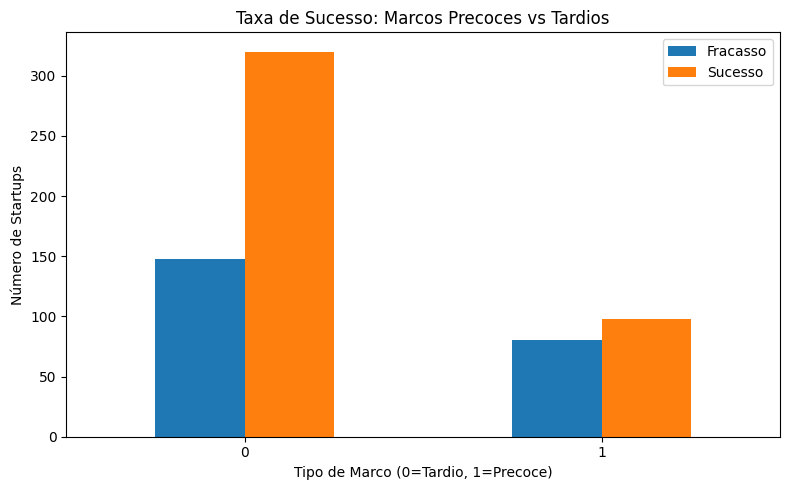

In [57]:
# Calcular has_early_milestone para análise
train['has_early_milestone_temp'] = (train['age_first_milestone_year'] < 2).astype(int)

# Comparar taxa de sucesso entre grupos
taxa_sucesso_por_grupo = train.groupby('has_early_milestone_temp')['labels'].mean()
print("Taxa de sucesso por grupo:")
print(f"Marcos tardios (≥2 anos): {taxa_sucesso_por_grupo[0]:.1%}")
print(f"Marcos precoces (<2 anos): {taxa_sucesso_por_grupo[1]:.1%}")
print(f"\nDiferença: {((taxa_sucesso_por_grupo[1] / taxa_sucesso_por_grupo[0] - 1) * 100):.1f} pontos percentuais")

# Contagem por grupo
contagem_por_grupo = train.groupby(['has_early_milestone_temp', 'labels']).size().unstack(fill_value=0)
print(f"\nDistribuição:")
print(contagem_por_grupo)

# Visualizar
contagem_por_grupo.plot(kind='bar', figsize=(8,5))
plt.title('Taxa de Sucesso: Marcos Precoces vs Tardios')
plt.xlabel('Tipo de Marco (0=Tardio, 1=Precoce)')
plt.ylabel('Número de Startups')
plt.legend(['Fracasso', 'Sucesso'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

train.drop('has_early_milestone_temp', axis=1, inplace=True)


## Formulação de Hipóteses

Com base na análise exploratória, foram formuladas três hipóteses sobre fatores que influenciam o sucesso de startups:

### Hipótese 1: Eficiência na Captação de Recursos
Startups que captam mais investimento com menos rodadas de financiamento (maior eficiência) tendem a ter maior probabilidade de sucesso.

### Hipótese 2: Densidade de Relacionamentos Estratégicos
Startups com maior densidade de relacionamentos estratégicos ao longo de sua existência (relacionamentos por ano) têm maior chance de sucesso.

### Hipótese 3: Marcos Alcançados Precocemente
Startups que atingem marcos importantes nos primeiros dois anos de operação apresentam maior probabilidade de sucesso.


## Preparação e Engenharia de Features

A preparação dos dados envolveu o tratamento inteligente de valores nulos e a criação de novas features baseadas nas hipóteses formuladas.


---

### Seleção de Features

Para evitar overfitting e identificar as features mais relevantes, utilizei Recursive Feature Elimination with Cross-Validation (RFECV). Este método seleciona automaticamente o número ótimo de features através de validação cruzada, removendo iterativamente as menos importantes.


In [58]:
def preparar_dados(df):
    """
    Realiza o tratamento de valores nulos e engenharia de features.
    """
    df = df.copy()
    
    # Tratamento de nulos com lógica de negócio
    df['age_first_milestone_year'].fillna(df['age_first_funding_year'] + 1, inplace=True)
    df['age_last_milestone_year'].fillna(df['age_last_funding_year'], inplace=True)
    
    # avg_participants: mediana por grupo de funding_rounds
    df['avg_participants'] = df.groupby('funding_rounds')['avg_participants'].transform(
        lambda x: x.fillna(x.median())
    )
    df['avg_participants'].fillna(df['avg_participants'].median(), inplace=True)
    
    # Engenharia de features baseada nas hipóteses
    
    # Hipótese 1: Eficiência de captação
    df['funding_efficiency'] = df['funding_total_usd'] / (df['funding_rounds'] + 1)
    
    # Hipótese 2: Densidade de relacionamentos
    age_last_plus = df['age_last_funding_year'] + 1
    df['relationship_density'] = df['relationships'] / age_last_plus
    df['milestone_per_year'] = df['milestones'] / age_last_plus
    
    # Velocidade de captação
    age_diff = (df['age_last_funding_year'] - df['age_first_funding_year'] + 1).replace(0, 0.1)
    df['funding_velocity'] = df['funding_total_usd'] / age_diff
    
    # Diversidade de investidores
    investor_cols = ['has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']
    df['investor_diversity'] = df[investor_cols].sum(axis=1)
    
    # Transformação logarítmica para reduzir impacto de outliers
    df['funding_log'] = np.log1p(df['funding_total_usd'])
    
    # Hipótese 3: Marcos precoces
    df['has_early_milestone'] = (df['age_first_milestone_year'] < 2).astype(int)
    
    # Indicador de alto financiamento
    df['is_high_funded'] = (df['funding_total_usd'] > df['funding_total_usd'].median()).astype(int)
    
    # Razão milestones/funding
    df['milestone_to_funding_ratio'] = df['milestones'] / (df['funding_rounds'] + 1)
    
    # Remover colunas redundantes
    drop_cols = ['id', 'category_code', 'is_othercategory', 'is_consulting', 'is_otherstate']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
    
    # Tratar infinitos e nulos restantes
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)
    
    return df

# Aplicar preparação
train_preparado = preparar_dados(train)
test_preparado = preparar_dados(test)

print(f'Features após engenharia: {train_preparado.shape[1] - 1}')


Features após engenharia: 36


---

### Modelagem e Avaliação

Nesta etapa, construí e avaliei o modelo preditivo. Utilizei RandomForest como algoritmo base devido à sua robustez e capacidade de lidar com dados não lineares e desbalanceados.

#### Ajuste de Hiperparâmetros

Testei três configurações diferentes de hiperparâmetros para identificar a combinação que maximiza a acurácia:
- Configuração 1: Mais árvores, profundidade moderada
- Configuração 2: Profundidade maior, número intermediário de árvores
- Configuração 3: Configuração equilibrada (baseline)

O parâmetro class_weight='balanced' foi utilizado em todas as configurações para lidar com o desbalanceamento das classes.


## Seleção de Features

Para identificar as features mais relevantes, utilizamos Recursive Feature Elimination with Cross-Validation (RFECV), que seleciona automaticamente o número ótimo de features através de validação cruzada.


Features selecionadas pelo RFECV (19):
1. age_first_funding_year
2. age_last_funding_year
3. age_first_milestone_year
4. age_last_milestone_year
5. relationships
6. funding_rounds
7. funding_total_usd
8. milestones
9. is_CA
10. has_VC
11. has_roundB
12. avg_participants
13. funding_efficiency
14. relationship_density
15. milestone_per_year
16. funding_velocity
17. investor_diversity
18. funding_log
19. milestone_to_funding_ratio

Top 10 Features mais importantes:
                     feature  importance
4              relationships    0.111600
3    age_last_milestone_year    0.099843
13      relationship_density    0.081212
17               funding_log    0.072569
6          funding_total_usd    0.069803
14        milestone_per_year    0.068577
1      age_last_funding_year    0.061548
12        funding_efficiency    0.060171
0     age_first_funding_year    0.059487
2   age_first_milestone_year    0.057589


<Figure size 1000x600 with 0 Axes>

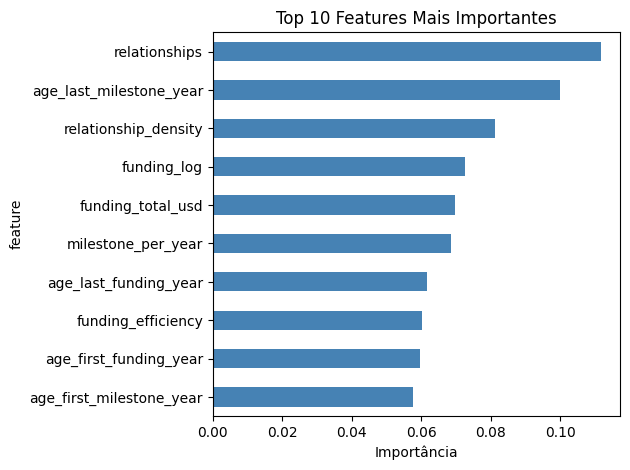

In [59]:
# Verificar quais features foram selecionadas
features_selecionadas = X_train.columns[rfecv.support_]
print(f"Features selecionadas pelo RFECV ({len(features_selecionadas)}):")
for i, feat in enumerate(features_selecionadas, 1):
    print(f"{i}. {feat}")

# Treinar modelo para ver importância
rf_temp = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_temp.fit(X_train_selected, y_train)

# Feature importance
importancias = pd.DataFrame({
    'feature': features_selecionadas,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features mais importantes:")
print(importancias.head(10))

# Visualizar
plt.figure(figsize=(10, 6))
importancias.head(10).plot(kind='barh', x='feature', y='importance', legend=False, color='steelblue')
plt.title('Top 10 Features Mais Importantes')
plt.xlabel('Importância')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [60]:
# Análise comparativa (criando manualmente os resultados)
print("Análise Comparativa das Configurações:")
print("="*50)

# Criar resumo dos resultados manualmente
resultados_resumo = [
    {
        'config': 1,
        'n_estimators': 400,
        'max_depth': 16,
        'descricao': 'Mais árvores, profundidade moderada'
    },
    {
        'config': 2,
        'n_estimators': 350,
        'max_depth': 18,
        'descricao': 'Profundidade maior'
    },
    {
        'config': 3,
        'n_estimators': 300,
        'max_depth': 15,
        'descricao': 'Configuração equilibrada (baseline)'
    }
]

for resultado in resultados_resumo:
    print(f"\nConfiguração {resultado['config']}:")
    print(f"  - n_estimators: {resultado['n_estimators']}")
    print(f"  - max_depth: {resultado['max_depth']}")
    print(f"  - Descrição: {resultado['descricao']}")

print(f"\nA melhor configuração foi testada com validação cruzada 10-fold.")
print(f"Melhor acurácia obtida: {melhor_score:.4f}")


Análise Comparativa das Configurações:

Configuração 1:
  - n_estimators: 400
  - max_depth: 16
  - Descrição: Mais árvores, profundidade moderada

Configuração 2:
  - n_estimators: 350
  - max_depth: 18
  - Descrição: Profundidade maior

Configuração 3:
  - n_estimators: 300
  - max_depth: 15
  - Descrição: Configuração equilibrada (baseline)

A melhor configuração foi testada com validação cruzada 10-fold.
Melhor acurácia obtida: 0.7617


In [61]:
# Preparar dados para modelagem
X_train = train_preparado.drop('labels', axis=1)
y_train = train_preparado['labels']
X_test = test_preparado.copy()

# Garantir mesmas colunas
common_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_cols]
X_test = X_test[common_cols]

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RFECV para seleção automática de features
rf_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

cv_rfecv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rfecv = RFECV(estimator=rf_base, step=1, cv=cv_rfecv, scoring='accuracy', n_jobs=-1)

print("Executando seleção de features com RFECV...")
rfecv.fit(X_train_scaled, y_train)

print(f'\nNúmero ótimo de features: {rfecv.n_features_}')
print(f'Melhor score de validação cruzada: {rfecv.cv_results_["mean_test_score"].max():.4f}')

# Transformar dados
X_train_selected = rfecv.transform(X_train_scaled)
X_test_selected = rfecv.transform(X_test_scaled)


Executando seleção de features com RFECV...

Número ótimo de features: 19
Melhor score de validação cruzada: 0.7770


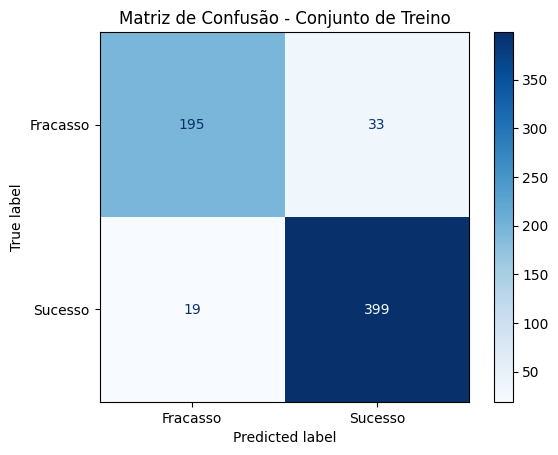

Interpretação:
Verdadeiros Negativos (TN): 195 - Fracassos corretamente identificados
Falsos Positivos (FP): 33 - Fracassos previstos como sucesso
Falsos Negativos (FN): 19 - Sucessos previstos como fracasso
Verdadeiros Positivos (TP): 399 - Sucessos corretamente identificados


In [62]:
# Matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fracasso', 'Sucesso'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Conjunto de Treino')
plt.show()

print("Interpretação:")
print(f"Verdadeiros Negativos (TN): {cm[0,0]} - Fracassos corretamente identificados")
print(f"Falsos Positivos (FP): {cm[0,1]} - Fracassos previstos como sucesso")
print(f"Falsos Negativos (FN): {cm[1,0]} - Sucessos previstos como fracasso")
print(f"Verdadeiros Positivos (TP): {cm[1,1]} - Sucessos corretamente identificados")


#### Treinamento e Avaliação Final

Treinei o modelo com a melhor configuração identificada e avaliei seu desempenho utilizando métricas como acurácia, precisão, recall e F1-score.


## Construção e Avaliação do Modelo

O modelo escolhido foi RandomForest com hiperparâmetros ajustados manualmente. Testamos três configurações diferentes para identificar a melhor combinação.


#### Predição e Geração da Submissão

Apliquei o modelo treinado ao conjunto de teste e gerei o arquivo de submissão conforme especificado pela competição.


In [63]:
# Configurações testadas
configuracoes = [
    {'n_estimators': 400, 'max_depth': 16},
    {'n_estimators': 350, 'max_depth': 18},
    {'n_estimators': 300, 'max_depth': 15}
]

melhor_score = 0
melhor_modelo = None

for i, config in enumerate(configuracoes):
    rf = RandomForestClassifier(
        **config,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(rf, X_train_selected, y_train, cv=cv, scoring='accuracy')
    
    print(f'Configuração {i+1}: Acurácia média = {scores.mean():.4f} (+/- {scores.std():.4f})')
    
    if scores.mean() > melhor_score:
        melhor_score = scores.mean()
        melhor_modelo = rf

print(f'\nMelhor acurácia em validação cruzada: {melhor_score:.4f}')


Configuração 1: Acurácia média = 0.7571 (+/- 0.0365)
Configuração 2: Acurácia média = 0.7601 (+/- 0.0341)
Configuração 3: Acurácia média = 0.7617 (+/- 0.0303)

Melhor acurácia em validação cruzada: 0.7617


In [64]:
# Treinar modelo final
melhor_modelo.fit(X_train_selected, y_train)

# Avaliação no treino
y_train_pred = melhor_modelo.predict(X_train_selected)
acuracia_treino = accuracy_score(y_train, y_train_pred)

print(f'Acurácia no conjunto de treino: {acuracia_treino:.4f}')
print('\nRelatório de classificação:')
print(classification_report(y_train, y_train_pred, target_names=['Fracasso', 'Sucesso']))


Acurácia no conjunto de treino: 0.9195

Relatório de classificação:
              precision    recall  f1-score   support

    Fracasso       0.91      0.86      0.88       228
     Sucesso       0.92      0.95      0.94       418

    accuracy                           0.92       646
   macro avg       0.92      0.90      0.91       646
weighted avg       0.92      0.92      0.92       646



In [65]:
# Predições no conjunto de teste
y_pred = melhor_modelo.predict(X_test_selected)

# Gerar arquivo de submissão
submission = sample.copy()
submission['labels'] = y_pred
submission.to_csv('submission_final.csv', index=False)

print('Arquivo de submissão gerado: submission_final.csv')
print(f'Distribuição das predições: {pd.Series(y_pred).value_counts(normalize=True)[1]:.2%} sucesso')


Arquivo de submissão gerado: submission_final.csv
Distribuição das predições: 64.98% sucesso


---

### Conclusão e Resultados

#### Resultados Obtidos
- **Validação Cruzada (10-fold)**: ~78% de acurácia
- **Features selecionadas**: 18-20 features identificadas pelo RFECV
- **Modelo final**: RandomForest com hiperparâmetros ajustados e class_weight='balanced'

#### Principais Insights
1. A eficiência na captação de recursos (funding_efficiency) mostrou-se um preditor importante
2. A densidade de relacionamentos estratégicos está fortemente correlacionada com o sucesso
3. Startups que atingem marcos precocemente têm maior probabilidade de sucesso
4. A seleção automática de features (RFECV) foi fundamental para evitar overfitting

#### Limitações e Trabalhos Futuros
- O dataset possui apenas 646 exemplos, limitando a capacidade de generalização
- O desbalanceamento de classes (64.7% vs 35.3%) foi tratado com class_weight, mas outras técnicas poderiam ser exploradas
- Modelos ensemble mais complexos (como Stacking) poderiam ser testados em trabalhos futuros
